In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from urllib2 import urlopen
import matplotlib.pyplot as plt
import unicodedata
import requests
import re

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [4]:
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [5]:
from sklearn import metrics

# Intro

This notebook contains the regressive model, to establish whether the predictor variables (book Ratings and weighted Book Ratings) by themselves can explain the response variables (Imdb, Rotten Tomatoes, and Metacritic, user and critic ratings).

In [6]:
df = pd.read_csv('dat_engRATE.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 14 columns):
Author             233 non-null object
Movie              233 non-null object
Rating             233 non-null float64
Rating_Count       233 non-null int64
Pages              233 non-null int64
Director           233 non-null object
Genre              233 non-null object
Metascore          233 non-null int64
Year               233 non-null int64
imdbRating         233 non-null float64
tomatoRating       233 non-null float64
tomatoU            233 non-null float64
logRating_Count    233 non-null float64
w_Rating           233 non-null float64
dtypes: float64(6), int64(4), object(4)
memory usage: 25.6+ KB


In [8]:
df_smaller = df.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'Pages', 'Metascore',
                          'Year', 'imdbRating', 'tomatoRating','tomatoU' ]]

In [9]:
df_smaller[:3]

,Rating,Rating_Count,w_Rating,logRating_Count,Pages,Metascore,Year,imdbRating,tomatoRating,tomatoU
0,4.11,169979,3.27,5.23,297,86,1968,8.3,9.1,3.8
1,3.95,7455,2.33,3.87,448,42,2002,6.2,4.1,3.1
2,3.79,109745,2.91,5.04,307,75,2002,7.1,7.7,2.8


In [10]:
len(df_smaller)

233

In [11]:

df_smaller.describe()

,Rating,Rating_Count,w_Rating,logRating_Count,Pages,Metascore,Year,imdbRating,tomatoRating,tomatoU
count,233.000000,2.330000e+02,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,3.878412,2.348458e+05,2.812446,4.746781,345.407725,60.137339,2003.854077,6.880687,6.244206,3.450644
std,0.255708,4.620934e+05,0.568249,0.812915,153.032764,17.067514,10.089906,0.890619,1.425650,0.397527
min,2.860000,4.350000e+02,1.510000,2.640000,32.000000,22.000000,1959.000000,4.100000,2.800000,2.000000
25%,3.720000,1.330500e+04,2.420000,4.120000,263.000000,47.000000,1999.000000,6.200000,5.200000,3.200000
50%,3.910000,6.010400e+04,2.830000,4.780000,324.000000,60.000000,2005.000000,6.900000,6.300000,3.500000
75%,4.050000,2.336350e+05,3.170000,5.370000,416.000000,74.000000,2012.000000,7.600000,7.400000,3.700000
max,4.530000,3.726471e+06,4.310000,6.570000,1168.000000,96.000000,2016.000000,8.800000,9.200000,4.300000


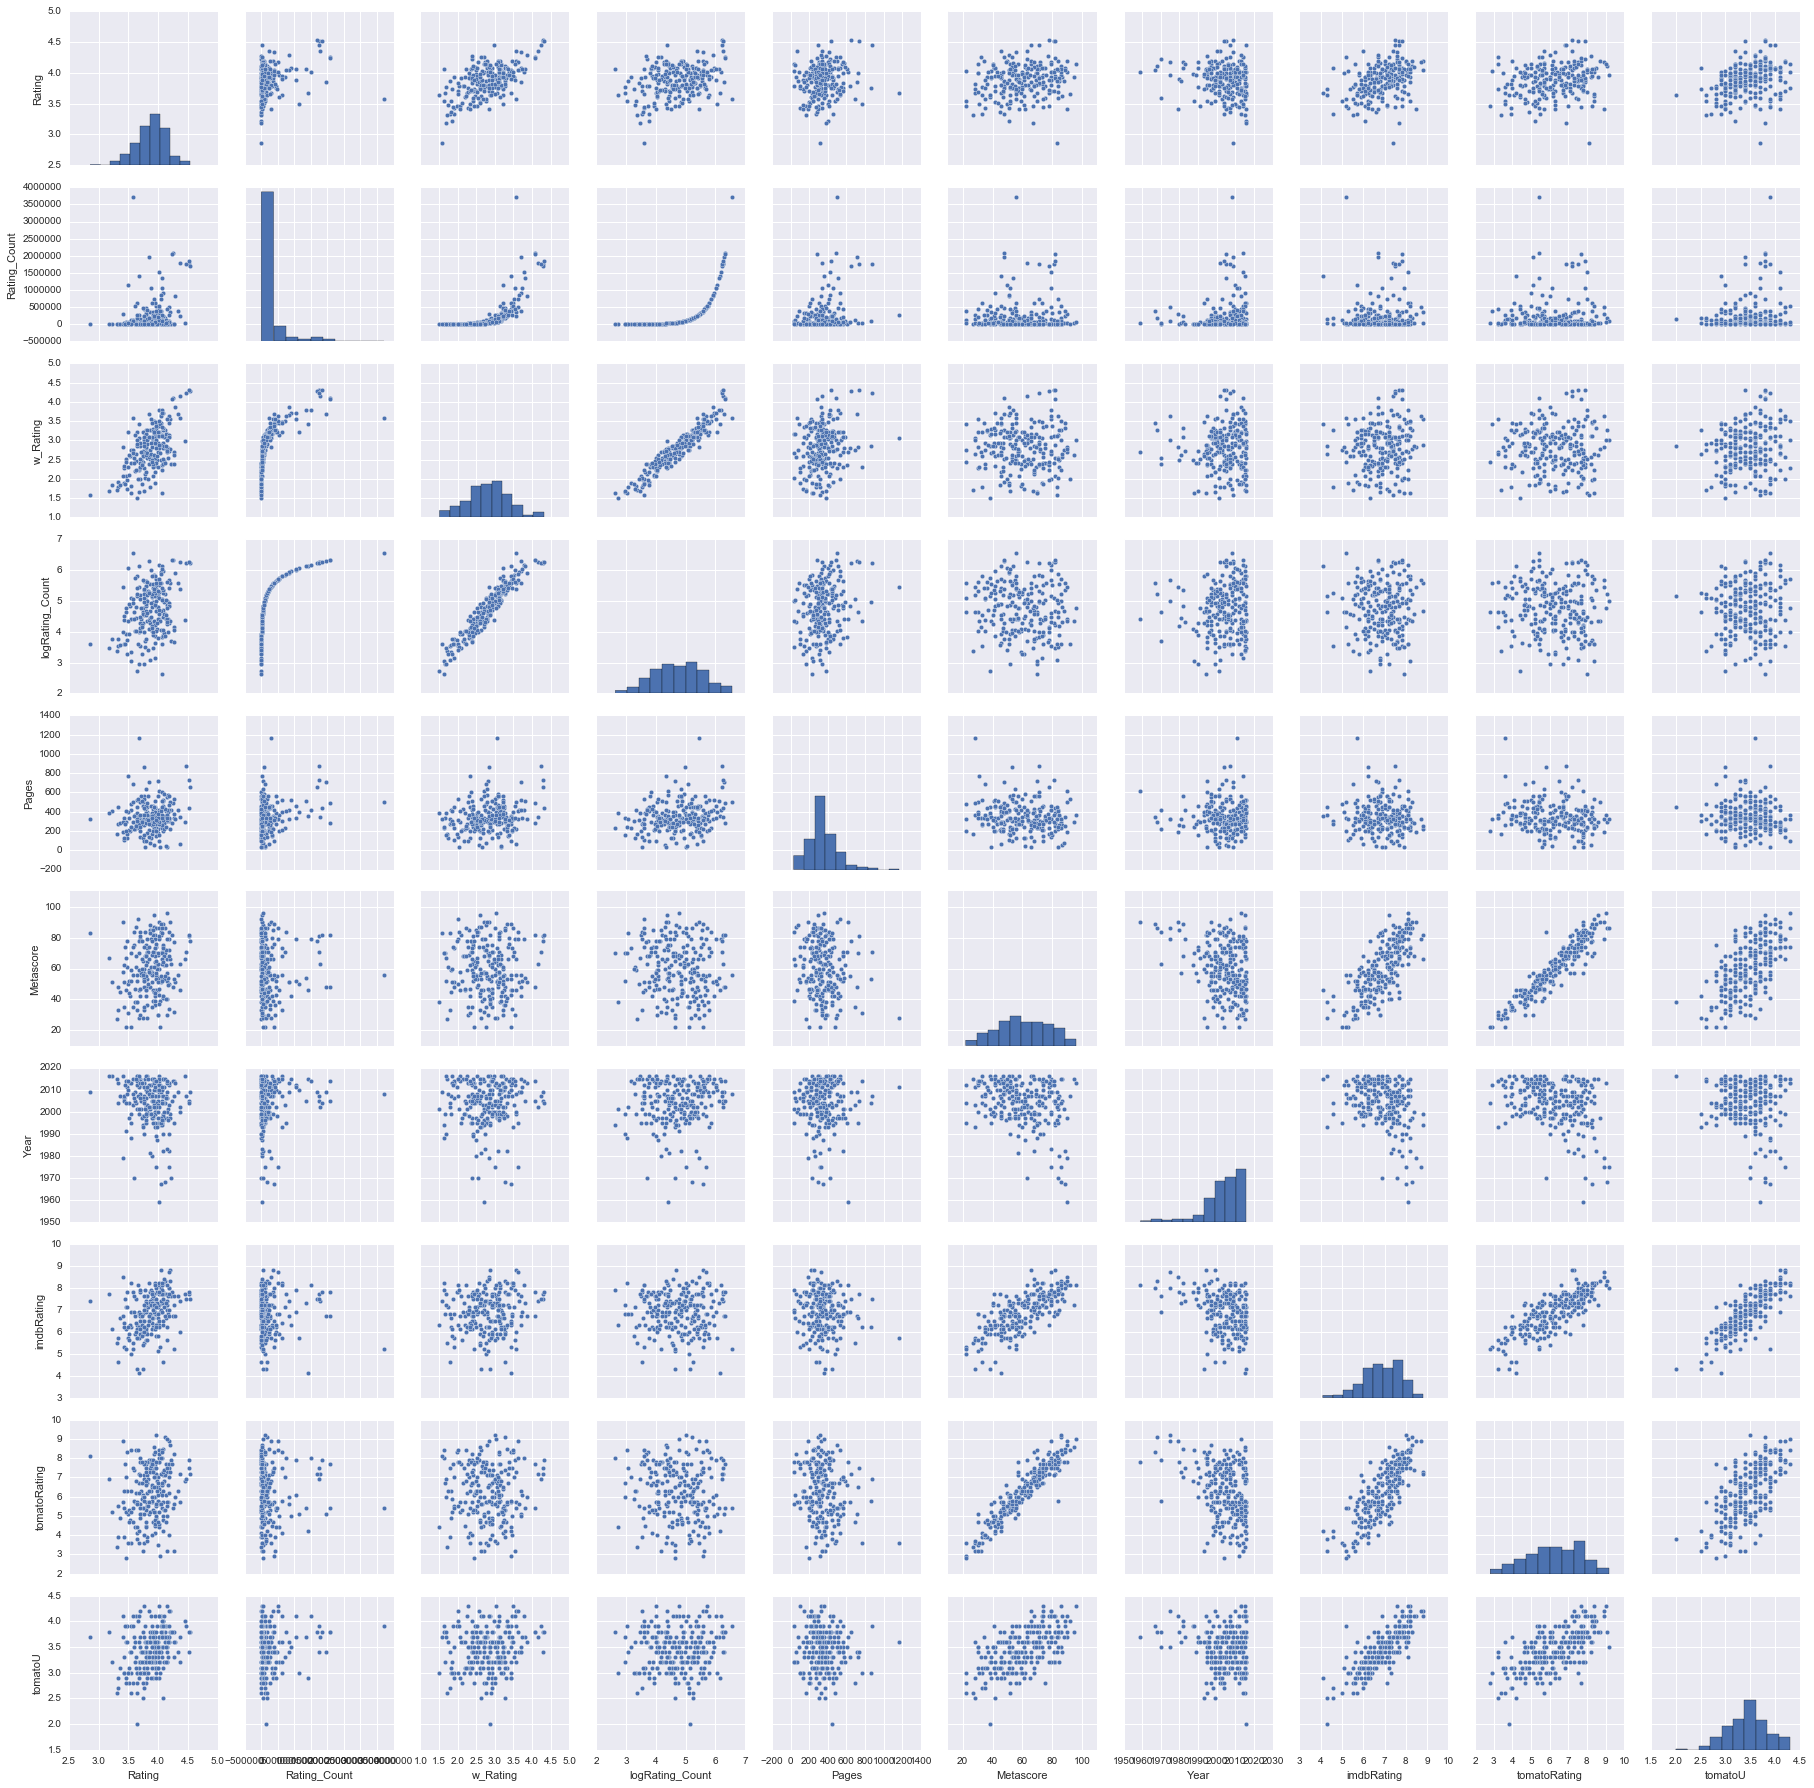

In [15]:

sns.pairplot(df_smaller)


Create a smaller Scatter Plot

''

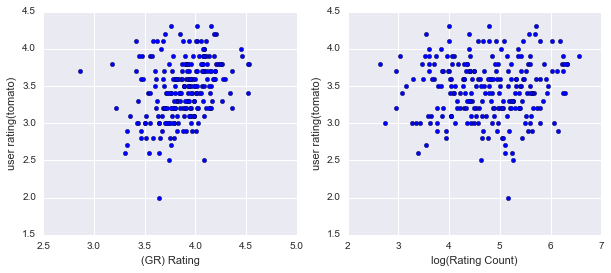

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(df_smaller.Rating, df_smaller.tomatoU)
ax[0].set_xlabel('(GR) Rating')
ax[0].set_ylabel('user rating(tomato)')
ax[1].scatter(df_smaller.logRating_Count, df_smaller.tomatoU)
ax[1].set_ylabel('user rating(tomato)')
ax[1].set_xlabel('log(Rating Count)')

plt.savefig('scatter_Correlation.eps', bbox_inches='tight',format='eps', dpi=1000)
;

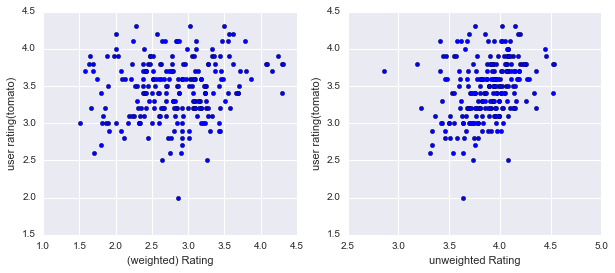

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(df_smaller.w_Rating, df_smaller.tomatoU)
ax[0].set_xlabel('(weighted) Rating')
ax[0].set_ylabel('user rating(tomato)')
ax[1].scatter(df_smaller.Rating, df_smaller.tomatoU)
ax[1].set_ylabel('user rating(tomato)')
ax[1].set_xlabel('unweighted Rating')

plt.savefig('scatter_Correlation.eps', bbox_inches='tight',format='eps', dpi=1000)

In [14]:
df_smaller.columns

Index([u'Rating', u'Rating_Count', u'w_Rating', u'logRating_Count', u'Pages',
       u'Metascore', u'Year', u'imdbRating', u'tomatoRating', u'tomatoU'],
      dtype='object')

In [15]:
# use a subset for X 

#X=df_smaller.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'Pages','tomatoU' ,'imdbRating', 
#                               'Year','tomatoRating']] #imdbRating', 'tomatoRating']]#, 'tomatoU' ]]
        
X = df_smaller.loc[:,:]

#### y = imdbRating (user based rating)

In [101]:
df_smaller.imdbRating.describe()
df_smaller.tomatoU.describe()

count    233.000000
mean       3.450644
std        0.397527
min        2.000000
25%        3.200000
50%        3.500000
75%        3.700000
max        4.300000
Name: tomatoU, dtype: float64

# Model test : does the weighted Rating have any predictive power, on ANY of the target variables? 

> 'Metascore','imdbRating', 'tomatoRating','tomatoU' 

w_rating: prediction on **imdbRating**


| Target var      |       RMS Rating| R-2 score|  RMS_weighted Rating| r2_score|describe Residuals?  |
| -------------    |:-------------:| --: |--: | --:-----:|
| imdbRating [1-10] | 0.74308246286       |**0.029544 ** |0.788166460865 | -0.92 | vertical line around prediction = 7 |
| tomatoU  [1-5]     |  0.37017975285    | **-0.0767**| 0.376674877984 |**-0.114849**|  similar residuals, just around 3.5 rather than 7 |
| tomatoRating  |  1.30216395707      |-0.0647 | 1.28994770543 |-0.044|  -  |
| Metascore [0 -100]     | 16.3278631294      |-0.07046422 | 16.0523805719| -0.03464734|  - |


**Metascore  v.  Rating has the least horrible residual plots ** (although they still contain a lot of non-randomness). The weighted ratings predictor actually produces worse residual plots in all the cases. 

However all of the R-2 scores are atrocious, suggesting that the model does not explain the variability in the data, and some transformations/additons of the data is in order


+ simplest model
fit the rating, and the weighted rating against the IMDB
+ Predict IMDB Rating
    + Tomato rating 
    + Metacritic
    
    
### R^2 values: 
    

In [83]:
responses = ['imdbRating', 'tomatoRating','tomatoU','Metascore']
predictor = ['w_Rating','Rating']

In [150]:
re_name = responses[0]
pred_name = predictor[1]

selected_columns = [pred_name]
y = df_smaller[re_name]

print(re_name, '\t',pred_name)

imdbRating 	 Rating


In [151]:
#Split the data 70-30 train/test
''' randomly select 30% of rows and choose to be the test-set
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [152]:
### DEFINE A MODEL OBJECT (LinearRegression)
lr_model1 = LinearRegression()

"""### that Object always has a fit method
    ### give matrix of predictors: X
    ### and vector of results : y 
    TRAIN SET is 70% of data
    >> your test set should be just big enough to give an accurate evalutation
"""
lr_model1.fit(X_train.loc[:,selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [153]:
list(zip(X_train.columns,lr_model1.coef_))

[('Rating', 1.391469714596868)]

In [154]:
lr_model1.coef_, lr_model1.intercept_

(array([ 1.39146971]), 1.4293649993159825)

In [155]:
test_set_pred = lr_model1.predict(X_test.loc[:,selected_columns])

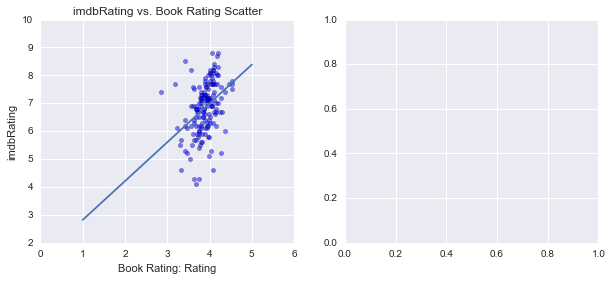

In [156]:
#plt.style.use('classic')http://theparkgym.com/schedule/l
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(X_train[pred_name], y_train, alpha=0.5)
ax[0].set_xlabel('Book Rating: {}'.format(pred_name))
ax[0].set_ylabel(re_name)
ax[0].set_title("{} vs. Book Rating Scatter".format(re_name))
vec1=np.linspace(1,5)
ax[0].plot(vec1, lr_model1.intercept_ + lr_model1.coef_[0]*vec1);

In [157]:
#RMSE
print ("RMSE ", np.sqrt(np.mean((test_set_pred - y_test)**2)))
#MAD
print ("MAD" ,(np.mean(np.abs(test_set_pred - y_test))))
print (metrics.r2_score(y_test,test_set_pred))

RMSE  0.74308246286
MAD 0.613848639284
0.0295441629011


** as a rule: **
residuals should not contain any predictive information 


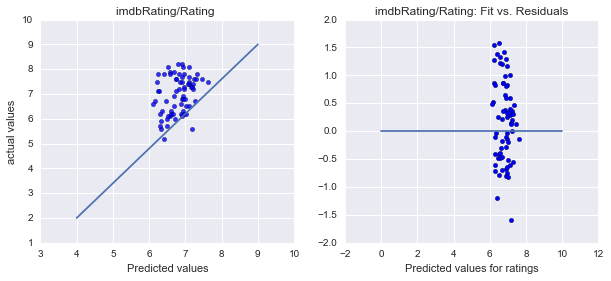

In [159]:
###### Residuals Metascore and w_Ratings
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(test_set_pred,y_test, alpha=0.8)
#ax[0].set_xlim(4,10)#ax[0].set_ylim(4,10)
ax[0].plot(np.linspace(4,9), np.linspace(2,9))
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('actual values')
ax[0].set_title("{}/{} ".format(re_name, pred_name))

lin_reg_residuals = y_test - test_set_pred
ax[1].scatter(test_set_pred, lin_reg_residuals)
ax[1].plot([0,10], [0, 0])
ax[1].set_xlabel('Predicted values for ratings')
ax[1].set_title("{}/{}: Fit vs. Residuals".format(re_name, pred_name))


### Residual plots:
+ Metascore and Ratings
+ TomatoRatings and Ratings
+ TomatRatings and weighted Ratings

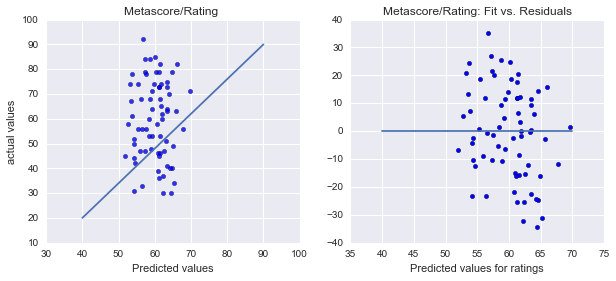

In [140]:
###### Residuals Metascore and Ratings
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(test_set_pred,y_test, alpha=0.8)
#ax[0].set_xlim(4,10)#ax[0].set_ylim(4,10)
ax[0].plot(np.linspace(40,90), np.linspace(20,90))
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('actual values')
ax[0].set_title("{}/{} ".format(re_name, pred_name))

lin_reg_residuals = y_test - test_set_pred
ax[1].scatter(test_set_pred, lin_reg_residuals)
ax[1].plot([40,70], [0, 0])
ax[1].set_xlabel('Predicted values for ratings')
ax[1].set_title("{}/{}: Fit vs. Residuals".format(re_name, pred_name))


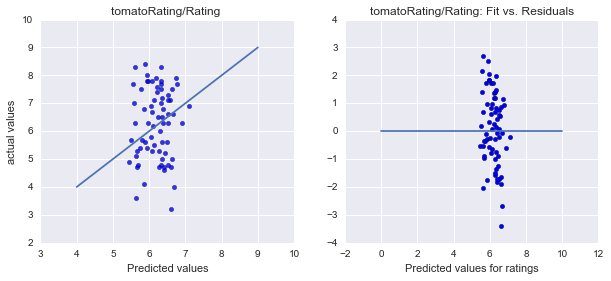

In [127]:
###### Residuals
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(test_set_pred,y_test, alpha=0.8)
#ax[0].set_xlim(4,10)#ax[0].set_ylim(4,10)
ax[0].plot(np.linspace(4,9), np.linspace(4,9))
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('actual values')
ax[0].set_title("{}/{} ".format(re_name, pred_name))

lin_reg_residuals = y_test - test_set_pred
ax[1].scatter(test_set_pred, lin_reg_residuals)
ax[1].plot([0,10], [0, 0])
ax[1].set_xlabel('Predicted values for ratings')
ax[1].set_title("{}/{}: Fit vs. Residuals".format(re_name, pred_name))


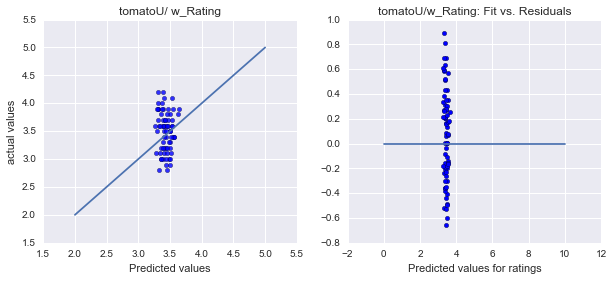

In [105]:
###### Residuals
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(test_set_pred,y_test, alpha=0.8)
#ax[0].set_xlim(4,10)#ax[0].set_ylim(4,10)
ax[0].plot(np.linspace(2,5), np.linspace(2,5))
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('actual values')
ax[0].set_title("{}/ w_Rating".format(re_name))

lin_reg_residuals = y_test - test_set_pred
ax[1].scatter(test_set_pred, lin_reg_residuals)
ax[1].plot([0,10], [0, 0])
ax[1].set_xlabel('Predicted values for ratings')
ax[1].set_title("{}/{}: Fit vs. Residuals".format(re_name, pred_name))


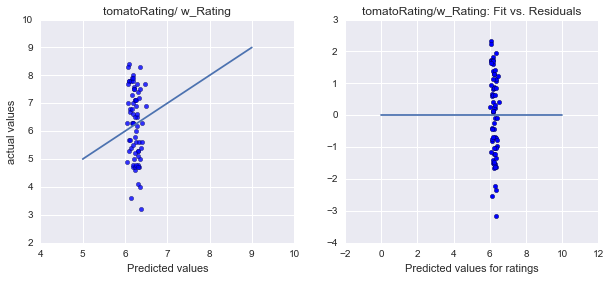

In [64]:
######
###### DO NOT RE-RUN #####  tomotoRating/ compare

fig, ax = plt.subplots(1,2, figsize=(10,4))

#ax[0].scatter(y_test,test_set_pred, alpha=0.8)

ax[0].scatter(test_set_pred,y_test, alpha=0.8)
#ax[0].set_xlim(4,10)#ax[0].set_ylim(4,10)
ax[0].plot(np.linspace(5,9), np.linspace(5,9))
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('actual values')
ax[0].set_title("{}/ w_Rating".format(re_name))

lin_reg_residuals = y_test - test_set_pred
ax[1].scatter(test_set_pred, lin_reg_residuals)
ax[1].plot([0,10], [0, 0])
ax[1].set_xlabel('Predicted values for ratings')
ax[1].set_title("{}/w_Rating: Fit vs. Residuals".format(re_name))



Looking at the residuals of weighted rating: w_Rating vs. Tomato Rating, AND the Predicted values vs. actual values ** the model can'tt ellthe difference between predicting a Movie rating of 6.0, or 6.5, predicts in that range for all actual values **

The prediction is wildly off for really high [7-9] or really low values [3-5] of Ratings.

Clearly the model needs to try some data transformation.
** Test if the same kind of Residual plots are seen with all other predictor/response combinations ** . The idea is to see if any of the Movie Ratings (esp. User Ratings) can be explained by book ratings

In [160]:
y_test.describe()

count    70.000000
mean      6.975714
std       0.759755
min       5.200000
25%       6.300000
50%       7.100000
75%       7.600000
max       8.200000
Name: imdbRating, dtype: float64

In [ ]:
### Residual plot above suggests the the model is skewed for higher Imdb values
# Plot Residuals

lin_reg_residuals = y_test - test_set_pred

plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

# Transforming the Variables

First let's look at if the distributions looks roughly bell-shaped. The following plots ARE bell-shaped. So why do the residuals look so insane? 

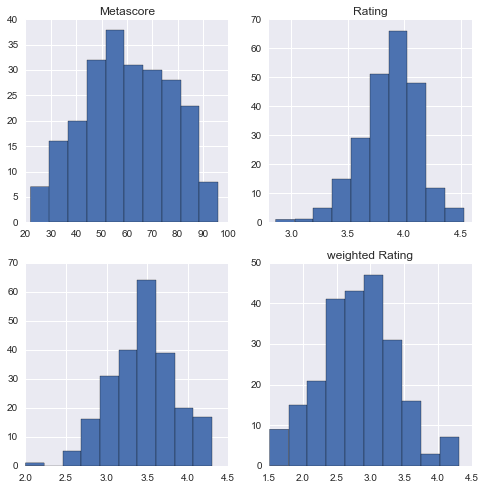

In [176]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

ax[0][0].hist(df_smaller.Metascore)
ax[0][0].set_title("Metascore")
ax[0][1].hist(df_smaller.Rating);
ax[0][1].set_title("Rating")
ax[1][1].hist(df_smaller.w_Rating);
ax[1][1].set_title("weighted Rating")
#ax[1][0].hist(df_smaller.tomatoRating)
ax[1][0].hist(df_smaller.tomatoU);



What about training data? 

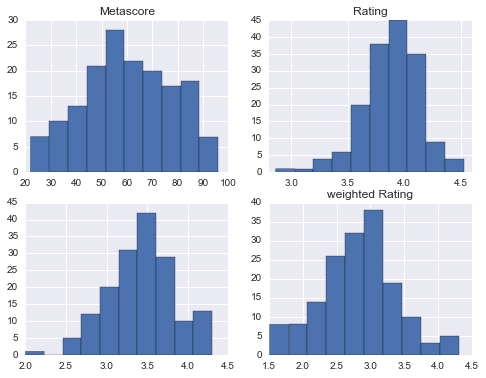

In [180]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0][0].hist(X_train.Metascore)
ax[0][0].set_title("Metascore")
ax[0][1].hist(X_train.Rating);
ax[0][1].set_title("Rating")
ax[1][1].hist(X_train.w_Rating);
ax[1][1].set_title("weighted Rating")
#ax[1][0].hist(df_smaller.tomatoRating)
ax[1][0].hist(X_train.tomatoU);

In [187]:
df_smaller['sqrRating'] = np.square(df_smaller.Rating)
df_smaller['sqrw_Rating'] = np.square(df_smaller.w_Rating)
df_smaller[:3]

,Rating,Rating_Count,w_Rating,logRating_Count,Pages,Metascore,Year,imdbRating,tomatoRating,tomatoU,sqrRating,sqrw_Rating
0,4.11,169979,3.27,5.23,297,86,1968,8.3,9.1,3.8,16.8921,10.6929
1,3.95,7455,2.33,3.87,448,42,2002,6.2,4.1,3.1,15.6025,5.4289
2,3.79,109745,2.91,5.04,307,75,2002,7.1,7.7,2.8,14.3641,8.4681


In [ ]:
# X[X['sqrRating'].isnull()]
# X[X['sqrRating'].isnull()]

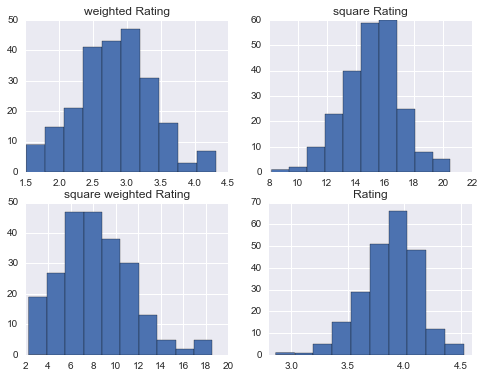

In [188]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0][0].hist(df_smaller.w_Rating)
ax[0][0].set_title("weighted Rating")
ax[1][0].hist(df_smaller.sqrw_Rating)
ax[1][0].set_title("square weighted Rating")
ax[0][1].hist(df_smaller.sqrRating);
ax[0][1].set_title("square Rating")
ax[1][1].hist(df_smaller.Rating);
ax[1][1].set_title("Rating")

Rating on its own is not a great predictor. Weighted rating on its own does a little better in terms of the R^2 value, but it also demonstrates an even stronger non-random error from the residual plot. Best is to consider more features



## Model 1b: considering a few more features

In [ ]:

X=df_smaller.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count']]#, 'Pages']]#,'tomatoU' ,'imdbRating', 
                               #'Year']]#,'tomatoRating']] #imdbRating', 'tomatoRating']]#, 'tomatoU' ]]
y = df_smaller['imdbRating']#['tomatoRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
lr_model_1b = LinearRegression()
lr_model_1b.fit(X_train,y_train)
print (list(zip(X_train.columns,lr_model_1b.coef_)) )
test_set_pred = lr_model_1b.predict(X_test)

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter( y_test,test_set_pred, alpha=0.8)
plt.plot(np.linspace(4,8), np.linspace(4,8))

plt.title('Plotting prediction of Rotten Tomato rating')
plt.ylabel('Predicted values')
plt.xlabel('Target values')

In [ ]:
#RMSE
print ("RMSE ", np.sqrt(np.mean((test_set_pred - y_test)**2)))
#MAD
print ("MAD" ,(np.mean(np.abs(test_set_pred - y_test))))
print (metrics.r2_score(y_test,test_set_pred))

**R-squared score is a little better/lower  when more features are considered** .and as can be seen below, the residual errors are a little bit more random (thought they still maintain a dependency with increasing imdb Score. 
Also root mean square error is lower. 

In [ ]:
# Plot Residuals

lin_reg_residuals = y_test - test_set_pred

plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

# Add square Rating ; do same
be careful about which dataframe using, df_smaller or X !!!

In [ ]:
X=X.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'sqrRating']]
y = df_smaller['imdbRating']#['tomatoRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
lr_model_3 = LinearRegression()
lr_model_3.fit(X_train,y_train)
print (list(zip(X_train.columns,lr_model_3.coef_)) )
test_pred_3 = lr_model_3.predict(X_test)

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter( y_test,test_pred_3, alpha=0.8)
plt.plot(np.linspace(4,8), np.linspace(4,8))

plt.title('Plotting prediction of Rotten Tomato rating')
plt.ylabel('Predicted values')
plt.xlabel('Target values')

In [ ]:
#RMSE
print ("RMSE ", np.sqrt(np.mean((test_pred_3 - y_test)**2)))
#MAD
print ("MAD" ,(np.mean(np.abs(test_pred_3 - y_test))))
print (metrics.r2_score(y_test,test_pred_3))

ok, RMSE is a little worse, and below residuals also seem to not improve

** could try other polynomial values, but doesn't seem to actually improve anything **


In [ ]:
# Plot Residuals
plt.figure()
lin_reg_residuals = y_test - test_pred_3

plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

# Random Forest Regressor? 

In [ ]:
X=X.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'sqrRating']]
y = df_smaller['imdbRating']#['tomatoRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
estimator.fit(X_train,y_train)
estimator.feature_importances_

In [ ]:
list(zip(X_train.columns,estimator.feature_importances_))

In [ ]:
scores = cross_val_score(estimator, X_train, y_train)
print ("Score from Random Forest Regressor {}".format( scores.mean()))

In [ ]:
#### predict with Random for est
rf_pred = estimator.predict(X_test)
# gives an array of scores

print ("RMSE ", np.sqrt(np.sum((rf_pred - y_test)**2)/len(y_test)) )


** using Random Forest, the RMSE is actually a little higher **

 

## Model 2: tomatoRating



In [ ]:
# use a subset for X 

X=df_smaller.loc[:,['Rating']]#, 'Rating_Count','w_Rating' ,'logRating_Count', 'Pages','tomatoU' ,'imdbRating', 
                               #'Year']]#,'tomatoRating']] #imdbRating', 'tomatoRating']]#, 'tomatoU' ]]

In [ ]:
y = df_smaller['tomatoRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:,selected_columns],y_train)
print (list(zip(X_train.columns,lr_model2.coef_)) )
test_set_pred = lr_model2.predict(X_test.loc[:,selected_columns])

In [ ]:
test_set_pred2 = lr_model2.predict(X_test.loc[:,selected_columns])

In [ ]:
# plot against test
plt.figure(figsize=(5,4))
plt.scatter( y_test,test_set_pred2, alpha=0.8)
plt.plot(np.linspace(4,8), np.linspace(4,8))

plt.title('Plotting prediction of RottenTomatoes rating')
plt.ylabel('Predicted values')
plt.xlabel('Target values')

#plt.savefig('tomato-CriticUser.eps', bbox_inches='tight',format='eps', dpi=1000)
;

In [ ]:
#RMSE
print ("RMSE ", np.sqrt(np.mean((test_set_pred2 - y_test)**2)))
#MAD
print ("MAD" ,(np.mean(np.abs(test_set_pred2 - y_test))))

In [ ]:
# Plot Residuals

lin_reg_residuals = y_test - test_set_pred2

plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

## Model 3: Metacritic

In [ ]:
# use a subset for X 

X=df_smaller.loc[:,['Rating', 'Rating_Count','w_Rating' ,'logRating_Count', 'Pages','tomatoU' ,'imdbRating', 
                               'Year','tomatoRating']] #imdbRating', 'tomatoRating']]#, 'tomatoU' ]]
        

In [ ]:
y = df_smaller['Metascore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
lr_model3 = LinearRegression()
lr_model3.fit(X_train.loc[:,selected_columns],y_train)
print (list(zip(X_train.columns,lr_model3.coef_)) )
test_set_pred3 = lr_model3.predict(X_test.loc[:,selected_columns])


In [ ]:
# plot against test
plt.figure(figsize=(5,4))
plt.scatter( y_test,test_set_pred3, alpha=0.8)
plt.plot(np.linspace(0,100), np.linspace(0,100))

plt.title('Plotting prediction of Metacritic rating')
plt.ylabel('Predicted values')
plt.xlabel('Target values')


In [ ]:
# Plot Residuals

lin_reg_residuals = y_test - test_set_pred3
plt.scatter(y_test, lin_reg_residuals)
plt.plot([0,10], [0, 0])
plt.title("Actual vs. Residuals")

In [ ]:
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [ ]:
# use overall Score as Target
#y = df_smaller['Metascore']

# user-based
#y = df_smaller['tomatoU']

# user-based
y = df_smaller['imdbRating']

In [ ]:
df_smaller[df_smaller['Rating'].isnull()]

In [ ]:
lr_model1.fit(X_train.loc[:,selected_columns],y_train)

In [ ]:
selected_columns = ['Rating']

# Cross-Val Model 1: 

In [ ]:
df_smaller.info()

In [ ]:
X.info()a


In [ ]:
len(X)

In [ ]:
len(X.dropna())

In [ ]:
len(X_train)

In [ ]:
# Holdout set
X_train, X_holdout, y_train,y_holdout = train_test_split(X.Rating,
                                                          y, test_size=0.2, random_state=42)

In [ ]:
# Trainng data into folds
# Notice that we are splitting the X_train data into 5 Folds
kfold = KFold(len(X_train), n_folds=5, shuffle=True, random_state=0)


In [ ]:
lin_reg_est = LinearRegression()

In [ ]:
#y_train[~y_train.isnull()] (np.mean(np.abs(test_set_pred - y_test)))

In [ ]:
# for train_rows, test_rows in kfold:
#     print(train_rows)

In [ ]:
fold_scores = np.zeros(5)
i = 0
for train_rows, test_rows in kfold:
    
    #lin_reg_est.fit(X_train.loc[train_rows, selected_columns], y_train[train_rows])
    lin_reg_est.fit(X_train[train_rows], y_train[train_rows])
    
    #test_pred = lin_reg_est.predict(X_train.loc[train_rows, selected_columns])
    test_pred = lin_reg_est.predict(X_train[train_rows])
    fold_scores[i] = np.mean(np.abs(test_pred -y_test)) 
    #mean_squared_error(y_train[test_rows],test_pred)
    i+=1
fold_scores

# Model 2:
select 
selected_columns = ['w_Rating']

In [ ]:
df_smaller.columns

In [ ]:

selected_columns = ['w_Rating']

In [ ]:
### DEFINE A MODEL OBJECT (LinearRegression)
lr_model2 = LinearRegression()

"""### that Object always has a fit method
    ### give matrix of predictors: X
    ### and vector of results : y 
    TRAIN SET is 70% of data
    >> your test set should be just big enough to give an accurate evalutation
"""
lr_model2.fit(X_train.loc[:,selected_columns],y_train)

In [ ]:
list(zip(X_train.columns,lr_model2.coef_))

In [ ]:
test_set_pred2 = lr_model2.predict(X_test.loc[:,selected_columns])

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(X_train['w_Rating'], y_train, alpha=0.5)


vec1=np.linspace(1,5)
plt.plot(vec1, lr_model2.intercept_ + lr_model2.coef_[0]*vec1);
#ax=sns.regplot(X_train['w_Rating'], y_train)
#plt.ylabel('imdbRating');

In [ ]:
#RMSE
np.sqrt(np.mean((test_set_pred2 - y_test)**2))

In [ ]:
#MAD
(np.mean(np.abs(test_set_pred2 - y_test)))

In [ ]:
# plot against test
plt.figure(figsize=(4,3))
plt.scatter(test_set_pred2, y_test, alpha=0.1)
plt.plot(np.linspace(6.4,7.5), np.linspace(3,10))

plt.ylabel('imdbRating');

# Model 3:
* combine and add maybe Year

In [ ]:
selected_columns = ['Rating','w_Rating', 'Year']

In [ ]:
### DEFINE A MODEL OBJECT (LinearRegression)
lr_model3 = LinearRegression()

"""### that Object always has a fit method
    ### give matrix of predictors: X
    ### and vector of results : y 
    TRAIN SET is 70% of data
    >> your test set should be just big enough to give an accurate evalutation
"""
lr_model3.fit(X_train.loc[:,selected_columns],y_train)

In [ ]:
#X_train.loc[:,selected_columns]

In [ ]:
list(zip(X_train.columns,lr_model3.coef_))

In [ ]:
test_set_pred3 = lr_model3.predict(X_test.loc[:,selected_columns])

In [ ]:
# plot against test
plt.figure(figsize=(4,3))
plt.scatter(test_set_pred3, y_test, alpha=0.1)
plt.plot(np.linspace(6.4,7.5), np.linspace(3,10))

plt.xlabel('X: Rating + Year')
plt.ylabel('imdbRating; ');

In [ ]:
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))

In [ ]:
# plot against test
plt.figure(figsize=(4,3))
plt.scatter(test_set_pred3, y_test, alpha=0.1)
plt.plot(np.linspace(6.4,7.5), np.linspace(3,10))

plt.xlabel('X: Rating + Year')
plt.ylabel('imdbRating; ');

In [ ]:
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))

# Model 4 : just year

In [ ]:
selected_columns = [ 'Year']

In [ ]:
### DEFINE A MODEL OBJECT (LinearRegression)
lr_model3 = LinearRegression()

"""### that Object always has a fit method
    ### give matrix of predictors: X
    ### and vector of results : y 
    TRAIN SET is 70% of data
    >> your test set should be just big enough to give an accurate evalutation
"""
lr_model3.fit(X_train.loc[:,selected_columns],y_train)

In [ ]:
lr_model3.coef_

In [ ]:
list(zip(X_train.columns,lr_model3.coef_))

In [ ]:
test_set_pred3 = lr_model3.predict(X_test.loc[:,selected_columns])

In [ ]:
# plot against test
plt.figure(figsize=(4,3))
plt.scatter(test_set_pred3, y_test, alpha=0.5)
plt.plot(np.linspace(6.4,7.5), np.linspace(3,10))

plt.xlabel('X: Year')
plt.ylabel('imdbRating; ');

In [ ]:
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))